In [39]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [40]:
trd = pd.read_csv('train.csv', keep_default_na=False)
tsd = pd.read_csv('test.csv')
td = pd.concat([trd, tsd], ignore_index=True, sort = False)


Text(0.5, 1.0, 'Missing values heatmap')

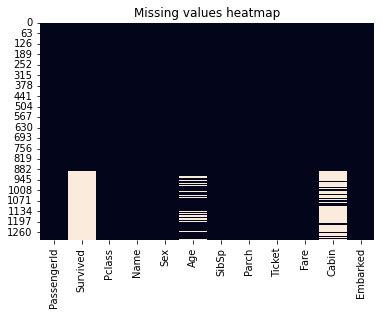

In [41]:
td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

In [42]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid', 'High_Mid','High'])

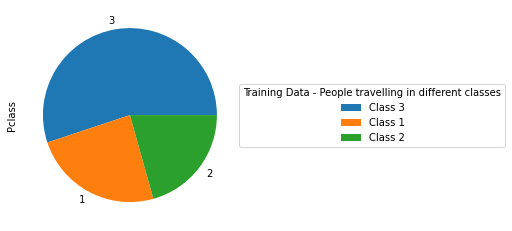

In [43]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")

In [44]:
print(trd.Pclass.value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64


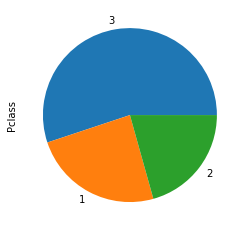

In [45]:
fig_pclass = trd.Pclass.value_counts().plot.pie()


Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

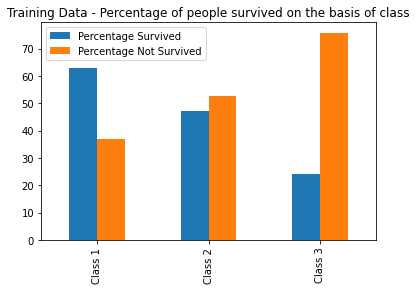

In [46]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Class 1": pclass_1_survivor_distribution,"Class 2": pclass_2_survivor_distribution, "Class 3": pclass_3_survivor_distribution},  
     "Percentage Not Survived":{"Class 1": 100-pclass_1_survivor_distribution,"Class 2": 100-pclass_2_survivor_distribution, "Class 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")



In [47]:
print (trd.notnull().any(axis = 0))

PassengerId    True
Survived       True
Pclass         True
Name           True
Sex            True
Age            True
SibSp          True
Parch          True
Ticket         True
Fare           True
Cabin          True
Embarked       True
dtype: bool


In [48]:
df = trd.loc[:, trd.notnull().any(axis = 0)]
print (df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38      1   
2                               Heikkinen, Miss. Laina  female  26      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35      1   
4                             Allen, Mr. William Henry    male  35      0   
..                                                 ...     ...  ..    ...   
886 

In [49]:
trd.loc[
    (trd['Pclass'] == 1) &
    (trd['Sex'] == 'female') & 
    (trd['Survived'] == 1)
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.5500,C103,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,,1,0,PC 17569,146.5208,B78,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45,1,1,36928,164.8667,,S
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48,0,0,17466,25.9292,D17,S
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47,1,1,11751,52.5542,D35,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56,0,1,11767,83.1583,C50,C


In [50]:
trd[
    (trd['Pclass'] == 2) &
    (trd['Sex'] == 'female') & 
    (trd['Survived'] == 1)
].value_counts()

PassengerId  Survived  Pclass  Name                                                                 Sex     Age  SibSp  Parch  Ticket      Fare     Cabin  Embarked
10           1         2       Nasser, Mrs. Nicholas (Adele Achem)                                  female  14   1      0      237736      30.0708         C           1
531          1         2       Quick, Miss. Phyllis May                                             female  2    1      1      26360       26.0000         S           1
601          1         2       Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)                  female  24   2      1      243847      27.0000         S           1
597          1         2       Leitch, Miss. Jessie Wills                                           female       0      0      248727      33.0000         S           1
581          1         2       Christy, Miss. Julie Rachel                                          female  25   1      1      237789      30.0000         S    

In [51]:
trd.loc[
    (trd['Pclass'] == 3) &
    (trd['Sex'] == 'female') & 
    (trd['Survived'] == 1)
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7000,G6,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,,0,0,2649,7.2250,,C
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15,0,0,330923,8.0292,,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
823,824,1,3,"Moor, Mrs. (Beila)",female,27,0,1,392096,12.4750,E121,S
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15,1,0,2659,14.4542,,C
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18,0,1,392091,9.3500,,S
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24,0,3,2666,19.2583,,C


In [52]:
print(trd['Sex'])

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object


In [53]:
# https://keras.io/api/models/sequential/
# https://keras.io/api/models/model/
# 
import tensorflow as tf

In [54]:
model = tf.keras.Sequential()
#  Input - Layer
model.add(tf.keras.layers.Dense(8, input_shape=(16,)))

In [55]:
model.add(tf.keras.layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(50, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(50, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(6, activation = "relu"))

In [56]:
# Output- Layer
model.add(tf.keras.layers.Dense(2, activation = "sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                450       
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                

In [57]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [58]:
#results = model.fit( trd, epochs = 3,  batch_size = 500, validation_data = tsd)

In [59]:
pd.get_dummies(trd.Sex, prefix="Sex", drop_first = False)

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [60]:
pd.get_dummies(trd.Embarked, prefix="Emb", drop_first = False)


,Emb_,Emb_C,Emb_Q,Emb_S
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
886,0,0,0,1
887,0,0,0,1
888,0,0,0,1
889,0,1,0,0


'With AGE'

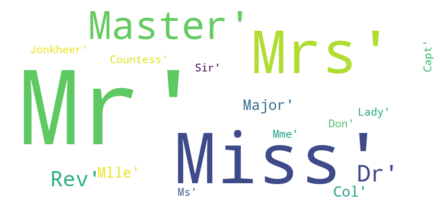

In [61]:
display('With AGE')
trd['Salutation'] = trd.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
trd.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(trd.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


'NO AGE'

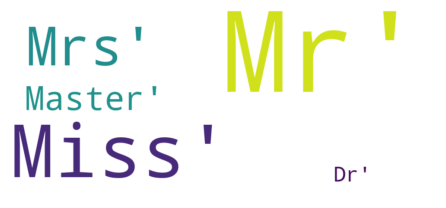

In [62]:
trd_no_age = trd.loc[trd.Age == ""]
trd_with_age = trd.loc[trd.Age != ""]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display (trd_no_age).Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display (trd_with_age).Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

display("NO AGE")
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(trd_no_age.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [63]:
master = trd_with_age[trd_with_age['Salutation'] == "Master"]  
#diplay(master)
display(master.Age.median())

3.5

In [64]:
miss = trd_with_age[trd_with_age['Salutation'] == "Miss"]  
#display(miss)
display(miss.Age.median())

21.0

In [65]:
mr = trd_with_age[trd_with_age['Salutation'] == "Mr"]  
#display(mr)
display(mr.Age.median())

30.0

In [66]:
mrs = trd_with_age[trd_with_age['Salutation'] == "Mrs"]  
#display(mrs)
display(mrs.Age.median())

doctor = trd_with_age[trd_with_age['Salutation'] == "Dr"]  
display(doctor)
display(doctor.Age.median())

35.0

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation
245,246,0,1,"Minahan, Dr. William Edward",male,44,2,0,19928,90.0000,C78,Q,Dr
317,318,0,2,"Moraweck, Dr. Ernest",male,54,0,0,29011,14.0000,,S,Dr
398,399,0,2,"Pain, Dr. Alfred",male,23,0,0,244278,10.5000,,S,Dr
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32,0,0,13214,30.5000,B50,C,Dr
660,661,1,1,"Frauenthal, Dr. Henry William",male,50,2,0,PC 17611,133.6500,,S,Dr
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49,0,0,17465,25.9292,D17,S,Dr


46.5

In [ ]:
#results = model.fit( trd, epochs = 3,  batch_size = 500, validation_data = tsd)